In [1]:
import copy
import random
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional 
import torch.optim 
import torch.utils.data

import torchvision.transforms
import torchvision.datasets
import torch.utils.data 
import skimage.io
import skimage.transform
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Cleaning Data

In [3]:
labels_filepath = 'data/10x_labels.csv'
labels=pd.read_csv(labels_filepath)

### Splitting Description column into shape and color

In [4]:
new= labels["Description"].str.split(" ", n = 1, expand = True)
labels.drop(columns=['Description'],inplace=True)

In [5]:
labels['Color'] = new[0].values
labels['Shape'] = new[1].values

### Decomposing Sample Keywords

In [6]:
sample_names = labels["Sample"].str.split(" ", n = 1, expand = False)

sample_names_frame = pd.DataFrame(sample_names)

        
        
labels['Sample'] = sample_names_frame

### Changing Identification to boolean is or is not plastic

In [7]:
labels['Identification'].unique()

array(['filter paper ', 'non-microplastic', 'polystyrene', 'Nylon',
       'filter paper', 'quartz', 'carbon fiber', 'orthoclase',
       'polypropylene', 'ink + plastic', 'PET', 'polyethylene',
       'fluorescence'], dtype=object)

In [8]:
plastics = ['polystyrene', 'polyethylene','polypropylene','Nylon','ink + plastic','PET','carbon fiber']
identification = labels['Identification']

for i in range(0,len(identification)):
    if identification[i] in plastics:
        identification[i] = True
    else:
        identification[i] = False
    
labels['Identification']=identification
labels.rename(columns={'Identification': 'isPlastic'}, inplace=True)
labels.head(5)

/Users/Will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Will/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sample,Sample origin,Size (um),isPlastic,Color,Shape
0,[252_1],mussels,50,False,clear,irregular
1,[252_2],mussels,50,False,opaque,fiber
2,[252_3],mussels,25,False,opaque,spheroid
3,[252_4],mussels,75,True,opaque,fragment
4,[252_5],mussels,50,False,opaque,spheroid


### Shape/isPlastic/Color Encoding

In [9]:
labels['isPlastic'] = labels["isPlastic"].astype(int)

In [10]:
labels['Color'].unique()

array(['clear', 'opaque', 'white', 'dark', 'blue'], dtype=object)

In [11]:
shape_encoder = OneHotEncoder()

In [12]:
shape_encoder.fit_transform(labels[['Shape']]).toarray();

In [13]:
shape_encoder.get_feature_names()

array(['x0_fiber', 'x0_fragment', 'x0_irregular', 'x0_shard',
       'x0_spheroid'], dtype=object)

In [14]:
color_encoder = OneHotEncoder()
shape_encoder.fit_transform(labels[['Color']]).toarray();

In [15]:
labels.head(3)

,Sample,Sample origin,Size (um),isPlastic,Color,Shape
0,[252_1],mussels,50,0,clear,irregular
1,[252_2],mussels,50,0,opaque,fiber
2,[252_3],mussels,25,0,opaque,spheroid


# Custom Dataset

In [16]:
class tenX_dataset(torch.utils.data.Dataset):
    """"""
    
    #Initializes dataset. Is only used once during the creating on a 'tenX_dataset' class
    #transform is an optional parameter, it defaults to none if nothing is passed into the class
    def __init__(self, labels_frame, image_dir, transform):
        'Initialization'
        self.labels = labels_frame
        self.image_dir = image_dir
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform
        
    #Length of dataset
    def __len__(self):
        return len(self.labels)
    
    #Return an single image with labels based on given index
    def __getitem__(self, idx):
        print('getitem')
        image_id = self.labels['Sample'][idx]
        image_file = None
        image = None
        
        for filename in self.image_filenames:
            if len(image_id) == 1:
                if image_id[0] in filename:
                    #print(image_id)
                    image_file = filename
                    break
            else:
                if image_id[0] in filename and image_id[1] in filename:
                    #print(image_id)
                    image_file = filename
                    break
                
        if not image_file:
            #raise Exception('Could not find image file')
            image_file = self.image_filenames[0]
            image_filepath = os.path.join(self.image_dir, image_file)
            image = skimage.io.imread(image_filepath)
   
        else:
            image_filepath = os.path.join(self.image_dir, image_file)
            image = skimage.io.imread(image_filepath)

            #sample = {'image': image,
                    #'shape': self.labels['Shape'][idx],
                    #'color': self.labels['Color'][idx],
                    #'plastic': self.labels['isPlastic'][idx]}

                    
        sample = {'image': image, 'plastic': self.labels['isPlastic'][idx]}

        #This 'transform' will be where we specify how we edit the images (resize, 
        #change file type, data augmentation). It is defined outside this classs.
        if self.transform is not None:
            sample['image'] = self.transform(sample['image'])
        return sample

In [17]:
image_dir = 'data/images_10x'
labels_frame = labels



tenX = tenX_dataset(labels_frame, image_dir,None)

In [18]:
samples=[]
for i in range(len(tenX)):
    sample = tenX[i]
    samples.append(sample['image'])
    if i>10:
        break

#samples
#samples

getitem
getitem
getitem
getitem
getitem
getitem
getitem
getitem
getitem
getitem
getitem
getitem


In [19]:
count = 0
for im in samples:
    if type(im) != type(None):
        #plt.figure(count)
        #plt.imshow(im)
        count+=1

(480, 752, 3)


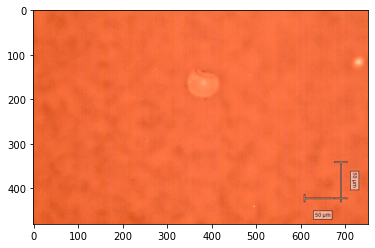

In [20]:
plt.imshow(samples[5])
print(np.shape(samples[5]))

# Things to improve/fix
* if data is for sure consistent. Take datacleaning steps, generalize, and put into a function. Then 10x_dataset class with get passed in the filename of the labels and in the init method the dataclean function should be called.
* Verify the labels are coming through (i.e. train some sort of model on this data
* Make sure the nonetypes are because the file actually isn't in my folder of images
* 252_1 is displayign 252_10 because of way code is written. 
* One hot encode categorical data

In [21]:
def get_mean_of_dataset(image_dataset):
    """"""
    

In [22]:
def get_std_of_dataset(image_dataset):
    """"""

In [23]:
def clean_labels(label_frame):
    """"""

# Start of me trying to plug into cnn

In [24]:
image_dir = 'data/images_10x'
labels_frame = labels
transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.Resize((480, 752)),
                            torchvision.transforms.ToTensor()
                                      ])


train_data = tenX_dataset(labels_frame, image_dir, transform = transform)

In [25]:
'''samples=[]
for i in range(len(tenX)):
    sample = tenX[i]
    samples.append(sample['image'])
    if i>10:
        break

count = 0
for im in samples:
    if type(im) != type(None):
        #plt.figure(count)
        #plt.imshow(im)
        print(np.shape(im))
        print(np.shape(transform(im)))
        count+=1'''

"samples=[]\nfor i in range(len(tenX)):\n    sample = tenX[i]\n    samples.append(sample['image'])\n    if i>10:\n        break\n\ncount = 0\nfor im in samples:\n    if type(im) != type(None):\n        #plt.figure(count)\n        #plt.imshow(im)\n        print(np.shape(im))\n        print(np.shape(transform(im)))\n        count+=1"

In [26]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [27]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 56
Number of validation examples: 7


In [28]:
BATCH_SIZE = 6

train_iterator = torch.utils.data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

In [76]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 8, 
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 8, 
                               out_channels = 12, 
                               kernel_size = 5)
        
        self.fc_1 = nn.Linear(6, 259740)
        self.fc_2 = nn.Linear(259740, 4329)
        self.fc_3 = nn.Linear(4329, output_dim)

    def forward(self, x):

        #x = [batch size, 1, 28, 28]
        
        x = self.conv1(x)
        
        #x = [batch size, 6, 24, 24]
        
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        
        #x = [batch size, 6, 12, 12]
        
        x = nn.functional.relu(x)
        
        x = self.conv2(x)
        
        #x = [batch size, 16, 8, 8]
        
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        
        #x = [batch size, 16, 4, 4]
        
        x = nn.functional.relu(x)
        
        x = x.view(x.shape[0], -1)
        
        #x = [batch size, 16*4*4 = 256]
        
        h = x
        
        x = self.fc_1(x)
        
        #x = [batch size, 120]
        
        x = nn.functional.relu(x)

        x = self.fc_2(x)
        
        #x = batch size, 84]
        
        x = nn.functional.relu(x)

        x = self.fc_3(x)

        #x = [batch size, output dim]
        
        return x, h

In [77]:
OUTPUT_DIM = 1
model = LeNet(OUTPUT_DIM)


criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters())

In [78]:
model = model.to(device)
criterion = criterion.to(device)

In [79]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [80]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for sample in iterator:
        image = sample['image'].to(device)
        isPlastic = sample['plastic'].to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(image)
        
        loss = criterion(y_pred, isPlastic)
        
        acc = calculate_accuracy(y_pred, isPlastic)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [81]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

getitem
getitem
getitem
getitem
getitem
getitem


RuntimeError: size mismatch, m1: [6 x 6], m2: [259740 x 4329] at /tmp/pip-req-build-9oilk29k/aten/src/TH/generic/THTensorMath.cpp:197